# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
openai = OpenAI()

In [4]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('../week6/test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [6]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [20]:
DB = "products_vectorstore"

In [21]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [22]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [23]:
description(test[0])

'GOLDTONE Brand Replacement Charcoal Water Filter Cartridges for Keurig Classic 1.0 and 2.0 Coffee Maker Machines 24 PACK\nHigh Quality replacement charcoal water wilter cartridge for keurig makers made after 2007 These replacement water filters are specifically designed for all Keurig brand coffee machines that require water filters made after 2007 Removes impurities (chlorine, odors, calcium & others) that interfere with taste and quality For Best Results Replace Every 60 Days or 60 Tank Refills. Works with Keurig 2.0 brewer, Elite B40, Classic B44, Ultra B50, Special Edition B60, Ultimate B66, Plantinum B70, Plantinum K79 Plus, Officepro B145'

In [24]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [25]:
def vector(item):
    return model.encode([description(item)])

In [26]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [27]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Flngr Pan Hanger (Right) for Refrigerator,Compatible
Part Numbers Pan Hanger (Right) for Refrigerator,Compatible Fits models FFHTXXX, FFTXXXX, FRTXXX. Note Before buying, please refer to the first picture or the sixth picture to make sure that you are buying in the correct direction. Quality Assurance High-quality materials and workmanship, 100% quality inspection. We offer 90-day free exchanges and 1-year free repairs on products sold. Left and Right The Pan Hanger is available in two symmetrical models (left) and (right). We offer sold separately, or you can buy both models at the same time. Manufacturer Flngr, Part Weight 2.89 ounces, Dimensions 17.52 x 2.05 x

Price is $10.00


In [28]:
documents, prices = find_similars(test[1])

In [29]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Flngr Pan Hanger (Left) for Refrigerator,Compatible
Part Numbers Pan Hanger (Left) for Refrigerator,Compatible Fits models FFHTXXX, FFTXXXX, FRTXXX, Note Before buying, please refer to the first picture or the sixth picture to make sure that you are buying in the correct direction. Quality Assurance High-quality materials and workmanship, 100% quality inspection. We offer 90-day free exchanges and 1-year free repairs on products sold. Left and Right The Pan Hanger is available in two symmetrical models (left) and (right). We offer sold separately, or you can buy both models at the same time. Manufacturer Flngr, Part Weight 2.89 ounces, Dimensions 17.68 x 2.05 x
Price is $9.49

Potentially related product:
Flngr Pan Hanger for Refrigerator,Fits models FFHTXXX, FFTXXXX, FRTXXX
Part Numbers Pan Hanger (Right) & Pan Hanger (Left). Right Fits models FFHTXX

In [30]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nFlngr Pan Hanger (Left) for Refrigerator,Compatible\nPart Numbers Pan Hanger (Left) for Refrigerator,Compatible Fits models FFHTXXX, FFTXXXX, FRTXXX, Note Before buying, please refer to the first picture or the sixth picture to make sure that you are buying in the correct direction. Quality Assurance High-quality materials and workmanship, 100% quality inspection. We offer 90-day free exchanges and 1-year free repairs on products sold. Left and Right The Pan Hanger is available in two symmetrical models (left) and (right). We offer sold separately, or you can buy both models at the same time. Manufacturer Flngr, Part Weight 2.89 ounces, Dimensions 17.68 x 2.05 x\nPrice is $9.49\n\nPotentially related product:\nFlng

In [31]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [32]:
get_price("The price for this is $99.99")

99.99

In [33]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [34]:
gpt_4o_mini_rag(test[1])

9.49

In [35]:
test[1].price

9.98

1: Guess: $16.99 Truth: $13.99 Error: $3.00 SLE: 0.03 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $9.49 Truth: $9.98 Error: $0.49 SLE: 0.00 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $649.00 Truth: $944.26 Error: $295.26 SLE: 0.14 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $49.99 Truth: $56.21 Error: $6.22 SLE: 0.01 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $10.99 Truth: $10.99 Error: $0.00 SLE: 0.00 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $17.99 Truth: $9.50 Error: $8.49 SLE: 0.35 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $18.74 Truth: $18.74 Error: $0.00 SLE: 0.00 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $70.15 Truth: $32.54 Error: $37.61 SLE: 0.57 Item: Frigidaire 297259528 Start Device, White
9: Guess: $21.50 Truth: $27.76 Error: $6.26 SLE: 0.06 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $254.99 Truth: $304.98 Error: $49.99 SLE: 0.03 Item: H

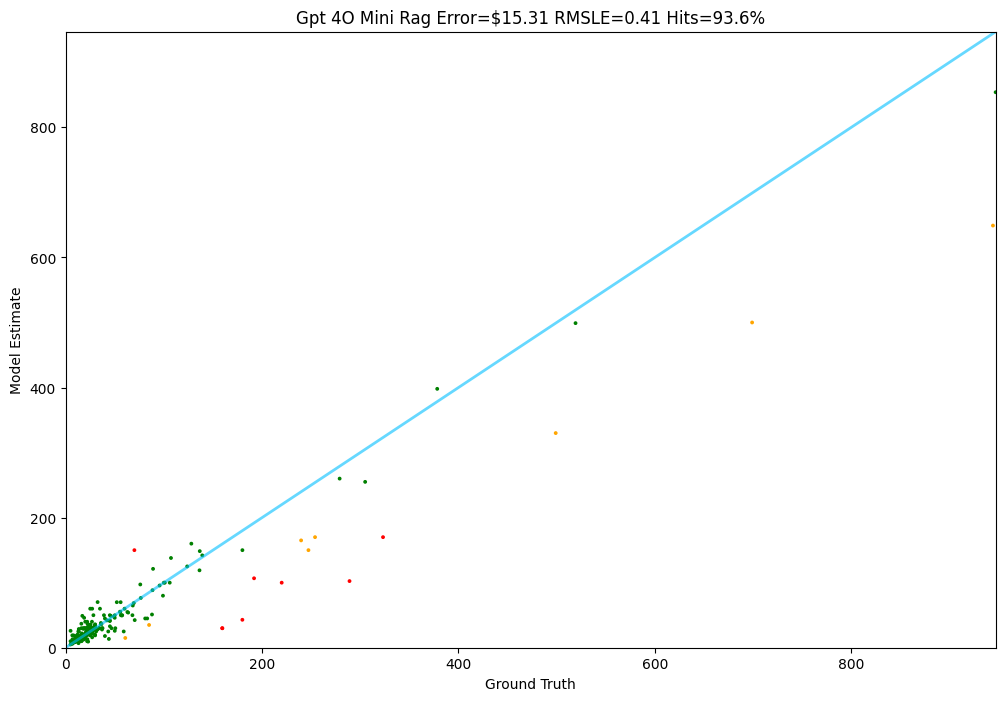

In [36]:
Tester.test(gpt_4o_mini_rag, test)

## Optional Extra: Trying a DeepSeek API call instead of OpenAI

If you have a DeepSeek API key, we will use it here as an alternative implementation; otherwise skip to the next section..

In [ ]:
# Connect to DeepSeek using the OpenAI client python library

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [ ]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek-chat", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [ ]:
deepseek_api_rag(test[1])

In [ ]:
Tester.test(deepseek_api_rag, test)

## And now to wrap this in an "Agent" class

In [41]:
from agents.frontier_agent import FrontierAgent

In [42]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [43]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [44]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $139.00


139.0

In [45]:
from agents.specialist_agent import SpecialistAgent

In [46]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal


NotFoundError: App not found

In [ ]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")